计算机视觉任务中，对图像的变换（Image Transform）往往是必不可少的操作，例如在迁移学习中，需要对图像尺寸进行变换以使用预训练网络的输入层，又如对数据进行增强以丰富训练数据。

作为深度学习领域的主流框架，pytorch中提供了丰富的图像变换API。本文将对pytorch中torchvision.transforms提供的丰富多样的图像变换API进行整理介绍。

 
为方便下文展示各种图像变换API的效果，我们借助matplotlib定义一个名为`show_image`函数来展示图片，如下所示：

In [1]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.io import read_image
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体支持

In [2]:
def show_image(img_lst, **imshow_kwargs):
    """
    img_lst: 保存图像和标题的list，形如：[(image1, title1),(image2, title2)]。image可以使Pillow.Image对象，也可以是torch.Tensor。
    imshow_kwargs: 需要传递给plt.imshow的参数
    """
    fig, axs =plt.subplots(1,len(img_lst), constrained_layout=True,  figsize=(2*len(img_lst),2), squeeze=False)
    for i, (img, title) in enumerate(img_lst):
        if isinstance(img, torch.Tensor):  # 如果是torch.Tensor类型，就必须转换成Pillow.Image类型，才能进行展示
            img = transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img), **imshow_kwargs)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(title)
    plt.show()

## 加载图片

### PIL库

对于存储在磁盘中的图片文件，使用Pillow库提供的Image类对象进行打开是一种十分常用的方法，如果你还没有安装，你可以通过以下命令方便下文进行：

```bash
pip install Pillow
```

In [3]:
from PIL import Image

我们通过Pillow中提供的方法，打开一张图片，并通过`show_image()`方法进行展示，下文中各种图像变换，我们都将以此图片为例，进行演示：



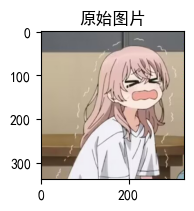

In [4]:
raw_img = (Image.open('sticker.jpeg'), '原始图片')
show_image([raw_img])

### pytorch中提供的图像加载方法

pytorch的torchvision.io模块本身也提供有加载图像数据的方法：read_image。该方法直接将图片加载为Tensor类型数据。



In [5]:
from torchvision.io import read_image


In [6]:
raw_img2 = read_image('sticker.jpeg')

In [7]:
raw_img2.shape


torch.Size([3, 338, 328])

In [8]:
type(raw_img2)

torch.Tensor

我们也通过之前定义的`show_image()`方法进行展示，注意，`show_image()`方法之所以能展示Tensor类型数据为图像，是因为`show_image()`方法内将Tensor转为PIL图像了。

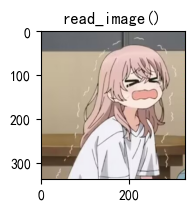

In [9]:
show_image([(raw_img2, 'read_image()')])

## transforms

### Compose

在介绍transforms前，有必要先说说Compose。

我们做图像变换时，一般都不会单独使用一个图像变换API，而是顺序使用多个API。对于多个API，transforms模块中提供Compose类，对多个API进行打包。Compose关键代码如下所示：

In [10]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

可见，在实例化Compose时，我们需要将用到的的API，按顺序存入列表（也可以是其他可迭代对象）中，传递给Compose。Compose内部机制，将会首先将图像传给第一个API，然后将经变换后的图像依次往后需API传递。如下所示，我们使用Compose对多个API进行组合：

In [11]:
preprocess = transforms.Compose([
   transforms.Resize(350),  # 变换尺寸
   transforms.CenterCrop(300),  # 裁切中心180像素
   transforms.ToTensor(),  # 转为Tensor类型
   transforms.Normalize(  # 标准化
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

In [12]:
raw_img = Image.open('sticker.jpeg')
x = preprocess(raw_img)
x.shape

torch.Size([3, 300, 300])

我们对边变换前后的图像：

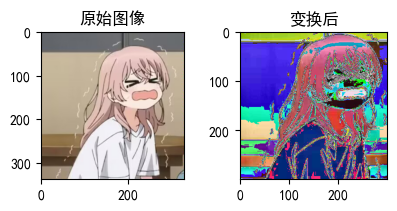

In [13]:
show_image([(raw_img, '原始图像'),(x, '变换后')])


### 自定义图像变换

transforms是pytorch中torchvision包提供的图像变换模块，提供了各式各样的图像变换API，这些API都是通过可调用对象，可以是函数、也可以是类，如果是类，就必须实现`__call__()`方法，至于返回的数据类型，并没有严格限制，只要后续的图像变换API能够接收就好，但就一般而言，最后一个API的都是Tensor类型数据。所以，如果自定义图像变换API，遵循这些规则去定义可调用对象就好。

最简单的，我们使用lambda定义可调用对象：

In [14]:
times_2_plus_1 = transforms.Compose([
    lambda x: x * 2,
    lambda x: x + 1,
])

In [15]:
times_2_plus_1(2)

5

当然，这并没有什么意义，只是实现将一个数字进行平方再加1的变换，这里只是演示函数方式实现变换器。接下来，我们试试类方式对图像进行变换，例如图像旋转：

In [16]:
class RandomRotation:
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, img):
        return F.rotate(img, self.angle)

In [17]:
raw_img = Image.open('sticker.jpeg')

In [18]:
tran_img = transforms.RandomRotation(60)(raw_img)

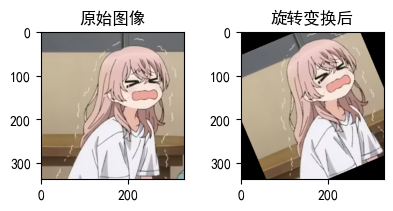

In [19]:
show_image([(raw_img, '原始图像'),(tran_img, '旋转变换后')])

在transforms模块中，pytorch对于多数变换都同时提供有类方式和函数方式的实现，但相较于函数，我更加推荐使用类的方式去实现变换，因为这种方式能够在实例化对象时，通过传递参数实现更加个性化的定制，例如进行尺寸变换，可以在构造方法中指定变换尺寸，这是函数方式无法做到的。函数方式更多是用在定义图像变换类使用使用，另外在功能固定、单一，使用函数方式实现也是不错的选择。

## pytorch中开箱即用的图像变换API

内存中的图像数据一般分为两种，一种是PIL的Image对象，一种是torch.Tensor(更严谨的说，应该是torch.*Tensor，因为也可以是Tensor的子类)，不要杠，我这里说的是建模过程中的图片形式，Python当然也可以用其他库来打开图片。相对应的，pytorch中的图像变换API也分为针对PIL.Image对象的API和针对Tensor数据的API以及能同时用于两种图像形式的API（姑且将这类API称为通用型图像变换API）。

**注意，即使是通用型API，也可能存在API内某些参数或参数值只适用于Tensor或PIL.Image**

我们先整理通用型的API。

### 通用型图像变换API

#### CenterCrop(size)

CenterCrop的作用是从图像的中心位置裁剪指定大小的图像。例如一些神经网络的输入图像大小为300×300，而我们上述展示的原始图像的大小为448×596，此时就需要对训练图像进行裁剪。

CenterCrop只有一个参数：

- size：裁切保留中央多少个像素
示例代码及结果如下：

In [20]:
raw_img2.shape


torch.Size([3, 338, 328])

PIL.Image类型数据裁切后输出类型为：<class 'PIL.Image.Image'>
torch.Tensor类型数据裁切后输出类型为：<class 'torch.Tensor'>


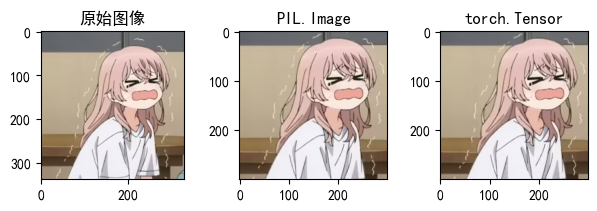

In [21]:
raw_img = Image.open('sticker.jpeg')
raw_img2 = read_image('sticker.jpeg')
size = (300, 300)
transform = transforms.CenterCrop(size)
tran_img1 = transform(raw_img)
tran_img2 = transform(raw_img2)
print(f'PIL.Image类型数据裁切后输出类型为：{type(tran_img1)}')
print(f'torch.Tensor类型数据裁切后输出类型为：{type(tran_img2)}')
show_image([
    (raw_img, '原始图像'),
    (tran_img1, 'PIL.Image'),   # 对PIL.Image类型图片进行裁切
    (tran_img2, 'torch.Tensor')  # 对torch.Tensor类型图片进行裁切
])

上述示例中，对PIL.Image类型和torch.Tensor类型数据进行了裁切，证明了CenterCrop这类通用型API并不会改变数据类型，输入什么类型的图像，输出还是什么类型的图像，另外从图像展示结果上看，对两种类型的图像变换的效果是一样的。

#### Resize(size)

按给定尺寸对图像进行缩放，Resize主要参数size可以为int型，此时，原始图像短边将缩放至size像素，长边将缩放至：size×长边÷短边 。以上述原始图片为例，假设输入size=300，原始图像短边高是448像素，长边宽是596像素，所以缩放后，长边宽为：300×596÷448=399像素；当size为序列时，size=(h, w)，原始图像将高和宽分别缩放至h和w。除了size参数外，Resize还有其他参数，可以参考[官方文档](https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.resize.html#torchvision.transforms.functional.resize)

size=300，缩放后图像宽高为：torch.Size([3, 309, 300])
size=(300, 300)，缩放后图像宽高为：torch.Size([3, 300, 300])


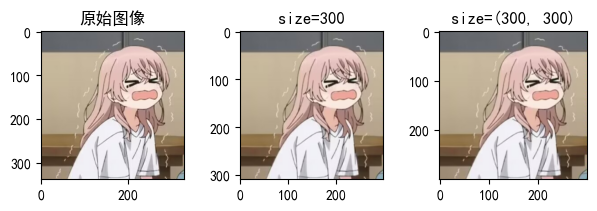

In [22]:
raw_img = read_image('sticker.jpeg')
size = (300, 300)
transform1 = transforms.Resize(size=300)
transform2 = transforms.Resize(size=(300, 300))
tran_img1 = transform1(raw_img)
tran_img2 = transform2(raw_img)
print(f'size=300，缩放后图像宽高为：{tran_img1.shape}')
print(f'size=(300, 300)，缩放后图像宽高为：{tran_img2.shape}')
show_image([
    (raw_img, '原始图像'),
    (tran_img1, 'size=300'),   # 对PIL.Image类型图片进行裁切
    (tran_img2, 'size=(300, 300)')  # 对torch.Tensor类型图片进行裁切
])

#### Pad(padding, fill=0, padding_mode='constant')

对图像边框进行填充，主要参数如下：

- **padding：指定填充像素**
  - 如果是整型，表示对4个边框都填充padding个像素值
  - 如果是长度为2的序列，例如，padding=(5, 10)，表示对左右边框填充5个像素值，上下边框填充10个像素值。
  - 如果是长度为4的序列，例如，padding=(5, 10, 15, 20)，表示对左、上、右、下分别填充5、10、15、20个像素值。
- **fill：填充的内容，默认值为0**。**注意，fill的值仅当padding_mode值为'constant'时有效。当输入图像为Tensor时，fill为int型才有效；当输入图像为PIL.Image时，fill既可以为int，也可以为序列**。
  - 当file是长度为3的序列是，分别用于填充R、G、B通道。
- **padding_mode：填充模式，即以什么内容填充。默认为值'constant'**
  - constant：常量填充，填充的内容由fill参数指定。
  - edge：用原始图像的最后一个像素值填充。
  - reflect：在边缘上不重复最后一个值的情况下，使用图像反射进行填充。例如，图像某一行像素为[1，2，3，4]，左右两边充填两个像素，因为不重复边界像素，左侧的像素值1和右侧的像素值4不进行反射，左侧就法则2和3，发射后成了3和2，填充到图像左侧，右侧反射2和3，反射后成了3和2，填充到图像右侧，最终这一行像素值变成[3，2，1，2，4，3，2]。
  - symmetric：就是reflect方式填充，只不过重复边界像素值。[1，2，3，4]使用这种方式填充后为[2, 1, 1, 2, 3, 4, 4, 3]。

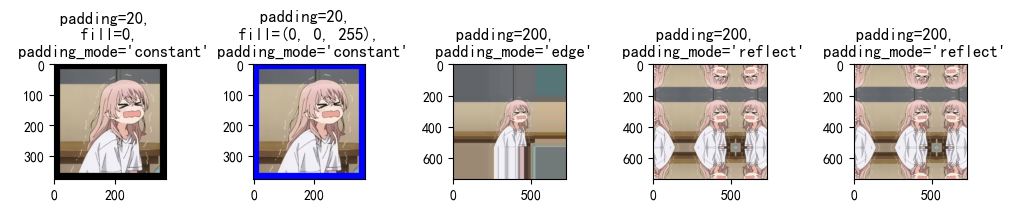

In [23]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        transforms.Pad(padding=20, fill=0, padding_mode='constant')(raw_img),
        "padding=20, \n fill=0, \n padding_mode='constant'"
    ),
    (
        transforms.Pad(padding=20, fill=(0, 0, 255), padding_mode='constant')(raw_img),
        "padding=20, \n fill=(0, 0, 255), \n padding_mode='constant'"
    ),
    (
        transforms.Pad(padding=200, padding_mode='edge')(raw_img),
        "padding=200, \n padding_mode='edge'"
    ),
    (
        transforms.Pad(padding=200, padding_mode='reflect')(raw_img),
        "padding=200, \n padding_mode='reflect'"
    ),
    
    (
        transforms.Pad(padding=200, padding_mode='symmetric')(raw_img),
        "padding=200, \n padding_mode='reflect'"
    ),
    
])

#### ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)

ColorJitter的作用是随机修改图片的亮度、对比度、饱和度、色调，常用来进行数据增强，尤其是训练图像类别不均衡或图像数量较少时。**注意，如果输入图像为PIL.Image对象，那么，如果打开模式为“1”, “I”, “F”或者图像透明，将会产生异常。**常用参数如下：

- brightness：亮度变换范围，默认值为0，即不变换亮度
  - 值为float时， 亮度将在[max(0, 1 - brightness), 1 + brightness] 范围变化。
  - 值为(min, max)时，亮度将在[min, max]范围内变化。不能为负数。
- contrast：对比度，默认值为0，即不变换对比度
  - 值为float时， 对比度将在[max(0, 1 - brightness), 1 + brightness] 范围变化。
  - 值为(min, max)时，对比度将在[min, max]范围内变化。不能为负数。
- saturation：饱和度，默认值为0，即不变换饱和度
  - 值为float时， 饱和度将在[max(0, 1 - brightness), 1 + brightness] 范围变化。
  - 值为(min, max)时，饱和度将在[min, max]范围内变化。不能为负数。
- hue：色调，默认值为0，即不变换色调
  - 值为float时， 色调将在[-hue, hue] 范围变化。
  - 值为(min, max)时，色调将在[min, max]范围内变化。取值建议：0<=hue<=0.5或-0.5<=min<=max<=0.5。

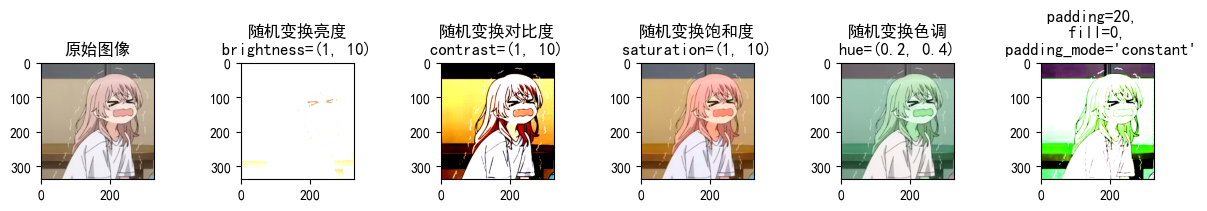

In [24]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.ColorJitter(brightness=(1, 10))(raw_img),
        "随机变换亮度\nbrightness=(1, 10)"
    ),
    (
        transforms.ColorJitter(contrast=(1, 10))(raw_img),
        "随机变换对比度\ncontrast=(1, 10)"
    ),
    (
        transforms.ColorJitter(saturation=(1, 10))(raw_img),
        "随机变换饱和度\nsaturation=(1, 10)"
    ),
    (
        transforms.ColorJitter(hue=(0.2, 0.4))(raw_img),
        "随机变换色调\nhue=(0.2, 0.4)"
    ),
    (
        transforms.ColorJitter(brightness=(1, 10), contrast=(1, 10), saturation=(1, 10), hue=(0.2, 0.4))(raw_img),
        "padding=20, \n fill=0, \n padding_mode='constant'"
    )
    
])

#### RandomRotation(degrees[, interpolation, ...])

指定角度范围随机旋转图像。

- degrees：旋转角度范围
  - 当值为(min, max)时，表示在(min, max)范围内随机选取一角度对图像进行旋转
  - 当值为数值时，等同于(-degrees, +degrees)
- interpolation：插值方式
- expand：是否对图像进行扩展，以展示整个旋转后图像。
- center：值为(a, b), 围绕图像中哪个点进行旋转, 默认围绕中心点旋转
- fill: 填充旋转后图像外的内容

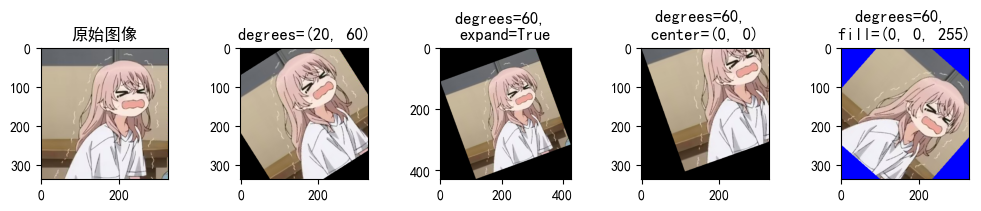

In [25]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomRotation(degrees=(20, 60))(raw_img),
        "degrees=(20, 60)"
    ),
    (
        transforms.RandomRotation(degrees=60, expand=True)(raw_img),
        "degrees=60, \nexpand=True"
    ),
    (
        transforms.RandomRotation(degrees=60, center=(0, 0))(raw_img),
        "degrees=60, \ncenter=(0, 0)"
    ),
    (
        transforms.RandomRotation(degrees=60, fill=(0, 0, 255))(raw_img),
        "degrees=60, \nfill=(0, 0, 255)"
    )
    
])

#### GaussianBlur(kernel_size[, sigma])

高斯模糊。

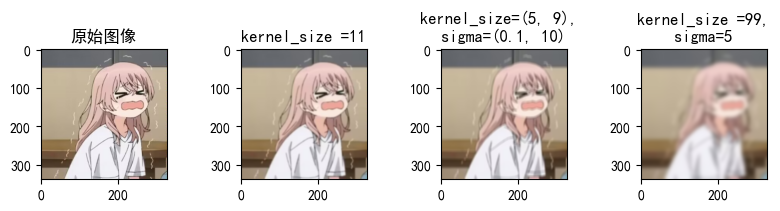

In [26]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.GaussianBlur(kernel_size =11)(raw_img),
        "kernel_size =11"
    ),
    (
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 10))(raw_img),
        "kernel_size=(5, 9), \nsigma=(0.1, 10)"
    ),
    (
        transforms.GaussianBlur(kernel_size =99,sigma=5)(raw_img),
        "kernel_size =99,\nsigma=5"
    )
    
])

#### FiveCrop(size)与 TenCrop(size, vertical_flip=False)

分别从图像的四个角以及中心进行五次裁剪，最终将返回一个包含5张裁切后图片的tuple。

- size：裁切尺寸
  - 当值为(h, w)时，在原始图像四个角以及中心各采取一张h × w的图像
  - 当值为int时，等同于(size, size)

转换后输出变量类型为：<class 'tuple'>, 输出变量长度为：5


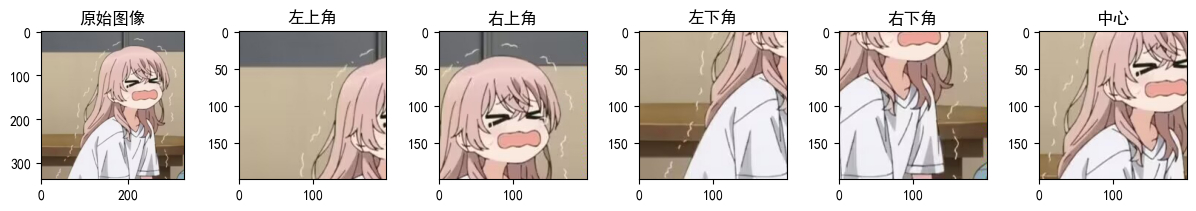

In [27]:
raw_img = Image.open('sticker.jpeg')
trans = transforms.FiveCrop((200, 200))
trans_imgs = trans(raw_img)
print(f'转换后输出变量类型为：{type(trans_imgs)}, 输出变量长度为：{len(trans_imgs)}')
show_image([
    (raw_img, '原始图像'),
    (trans_imgs[0], '左上角'),
    (trans_imgs[1], '右上角'),
    (trans_imgs[2], '左下角'),
    (trans_imgs[3], '右下角'),
    (trans_imgs[4], '中心'),
])

再来说TenCrop(size, vertical_flip=False)。

TenCrop(size, vertical_flip=False)就是在FiveCrop(size)的基础上，对原始图像进行水平或者垂直翻转，然后在从翻转后图像的四个角以及中心进行五次裁剪，所以一共获取了10张图像返回。参数vertical_flip默认值为False，表示进行水平翻转，值为True时，表示进行垂直翻转在裁剪。

#### Grayscale(num_output_channels=1) RandomGrayscale(p=0.1)

将图像转换为灰度图像，默认通道数为1，通道数为3时，RGB三个通道的值相等。

- num_output_channels ：指定最终输出图像的通道数，值为1时，最终输出只有一个通道的灰度图像，值为3时，输出三个通到值相等的灰度图像。默认值为1。

num_output_channels=1时，输出为：torch.Size([1, 338, 328])
num_output_channels=3时，输出为：torch.Size([3, 338, 328])


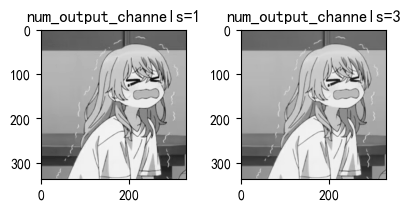

In [28]:
raw_img = read_image('sticker.jpeg')
transform1 = transforms.Grayscale(num_output_channels=1)
transform2 = transforms.Grayscale(num_output_channels=3)
tran_img1 = transform1(raw_img)
tran_img2 = transform2(raw_img)
print(f'num_output_channels=1时，输出为：{tran_img1.shape}')
print(f'num_output_channels=3时，输出为：{tran_img2.shape}')
show_image([
    (tran_img1, 'num_output_channels=1'),
    (tran_img2, 'num_output_channels=3')
], cmap='gray')

RandomGrayscale以一定的概率将图像变为灰度图像。实际上就是以一定的概率执行torchvision.transforms.Grayscale。参数只有一个概率值p，默认值为0.1。这里不再演示。

#### RandomSolarize(threshold, p=0.5)

以一定概率将超过给定阈值的像素值进行反转。

- threshold：反转像素阈值
- p: 概率值

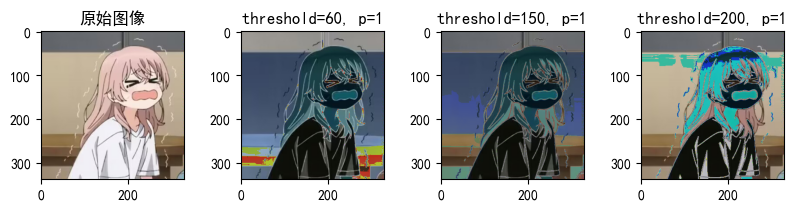

In [29]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomSolarize(threshold=60, p=1)(raw_img),
        "threshold=60, p=1"
    ),
    (
        transforms.RandomSolarize(threshold=150, p=1)(raw_img),
        "threshold=150, p=1"
    ),
    (
        transforms.RandomSolarize(threshold=200, p=1)(raw_img),
        "threshold=200, p=1"
    )
])

#### RandomAffine(degrees, translate=None, scale=None, shear=None, resample=False, fillcolor=0)

RandomAffine的作用是保持图像中心不变的情况下对图像进行随机的仿射变换。

- degrees：度数范围。
  - 值为（min，max）时，表示在（min，max）之间随机变换角度
  - 值为int时，等同于（-degrees，degrees）
- translate：位移距离。值为tuple类型，例如translate=（a，b），则在范围[-图像宽度 × a, 图像宽度 × a]中随机采样水平移位，在范围[-图像高度 × b, 图像高度 × b]中随机采样垂直移位。默认值为0，表示不进行位移。
- scale：缩放。值为tuple类型，例如translate=（a，b），表示在[a, b]范围内随机采样进行缩放，默认情况下将保持原始比例。
- shear:可从中选择的度数范围。仿射变换的角度。
- interpolation：插值的方法。
- fill:填充像素的值。默认为0.

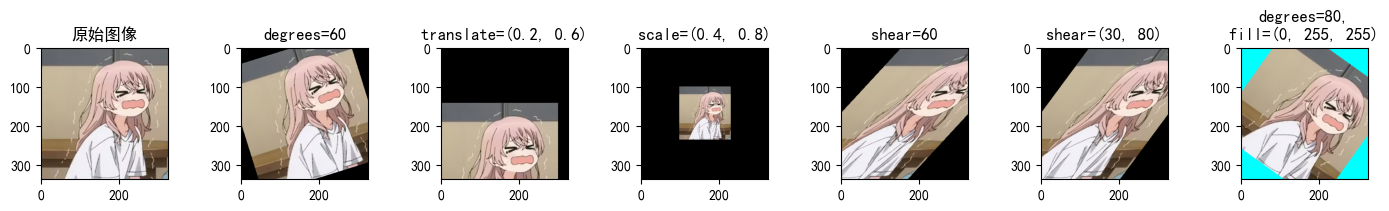

In [30]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomAffine(degrees=60)(raw_img),
        "degrees=60"
    ),
    (
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.6))(raw_img),
        "translate=(0.2, 0.6)"
    ),
    (
        transforms.RandomAffine(degrees=0, scale=(0.4, 0.8))(raw_img),
        "scale=(0.4, 0.8)"
    ),
    (
        transforms.RandomAffine(degrees=0, shear=60)(raw_img),
        "shear=60"
    ),
    (
        transforms.RandomAffine(degrees=0, shear=(30, 80))(raw_img),
        "shear=(30, 80)"
    ),
    (
        transforms.RandomAffine(degrees=80, fill=(0, 255, 255))(raw_img),
        "degrees=80,\nfill=(0, 255, 255)"
    ),
])

#### RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')

在一个随机位置上对图像进行裁剪。

- size：裁切保留多少个像素
  - 值为tuple，例如(h, w)，表示裁切尺寸为(h, w)
  - 值为int，等同于(size, size)
- padding：填充边框像素值
  - 如果是整型，表示对4个边框都填充padding个像素值
  - 如果是长度为2的序列，例如，padding=(5, 10)，表示对左右边框填充5个像素值，上下边框填充10个像素值。
  - 如果是长度为4的序列，例如，padding=(5, 10, 15, 20)，表示对左、上、右、下分别填充5、10、15、20个像素值。
- pad_if_needed：如果图像小于所需大小，它将先填充图像然后进行裁切以避免引发异常。由于裁剪是在填充之后完成的，所以填充似乎是以随机偏移量完成的。
- fill：填充的内容，默认值为0
- padding_mode：填充模式，即以什么内容填充。默认为值'constant'
  - constant：常量填充，填充的内容由fill参数指定。
  - edge：用原始图像的最后一个像素值填充。
  - reflect：在边缘上不重复最后一个值的情况下，使用图像反射进行填充。例如，图像某一行像素为[1，2，3，4]，左右两边充填两个像素，因为不重复边界像素，左侧的像素值1和右侧的像素值4不进行反射，左侧就法则2和3，发射后成了3和2，填充到图像左侧，右侧反射2和3，反射后成了3和2，填充到图像右侧，最终这一行像素值变成[3，2，1，2，4，3，2]。
  - symmetric：就是reflect方式填充，只不过重复边界像素值。[1，2，3，4]使用这种方式填充后为[2, 1, 1, 2, 3, 4, 4, 3]。

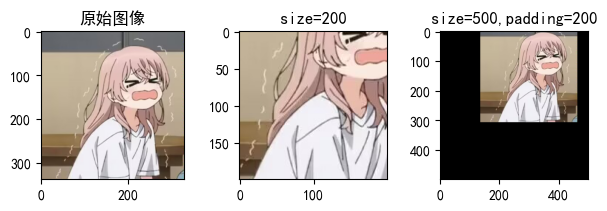

In [31]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomCrop(size=200)(raw_img),
        "size=200"
    ),
    (
        transforms.RandomCrop(size=500,padding=200)(raw_img),
        "size=500,padding=200"
    )
])

#### RandomHorizontalFlip(p=0.5)与RandomVerticalFlip(p=0.5)

以一定的概率将图像水平翻转。参数只有一个概率值p，默认值为0.5。

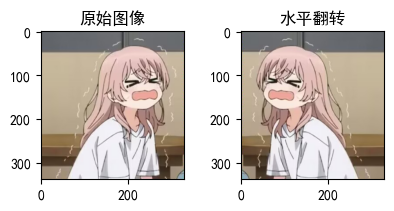

In [32]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomHorizontalFlip(p=1)(raw_img),
        "水平翻转"
    )
])

有水平翻转，就有垂直翻转，即RandomVerticalFlip(p=0.5)，用法与RandomHorizontalFlip(p=0.5)完全一致，这里不再介绍。

#### RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0)

以一定的概率对图像进行随机的透视变换。

- distortion_scale：扭曲的角度，取值在[0, 1]之间，默认值为0.5.
- p：执行变换的概率。
- interpolation：插值的方法。
- fill：填充的内容，默认值为0。

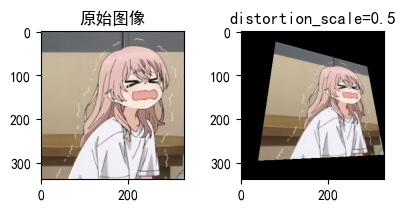

In [33]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomPerspective(distortion_scale=0.5)(raw_img),
        "distortion_scale=0.5"
    )
])

#### RandomEqualize(p=0.5)

以一定的概率均衡图像色调直方图。

- p：执行变换的概率。

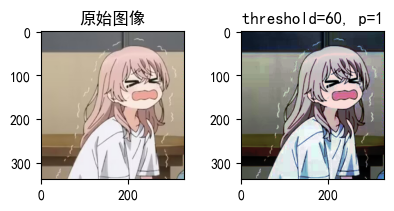

In [34]:
raw_img = Image.open('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomEqualize(p=1)(raw_img),
        "threshold=60, p=1"
    )
])

#### RandomApply(p=0.5)

以一定的概率执行一组图像变换API，要么全部执行，要么全不执行。

- p：执行变换的概率。

### 专用于PIL.Image的图像变换API

这种类型的API只有两个：RandomChoice和RandomOrder，官方文档指出，此类API只适用于PIL.Image类型图像。

#### RandomChoice(transforms[, p])

以一定的概率从多个图像变换API中选取一个对图像进行变换，注意：可能一个都不选取，即不执行变换。

- transforms：多个图像变换API组成的序列
- p：执行变换的概率。

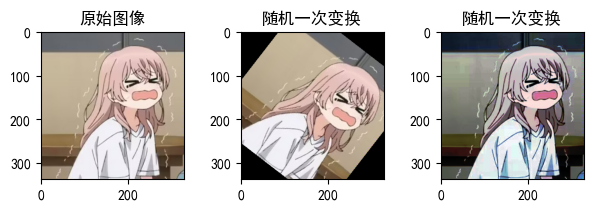

In [35]:
raw_img = Image.open('sticker.jpeg')

trans = transforms.RandomChoice([
    transforms.Resize(350),
    transforms.RandomEqualize(p=1),
    transforms.RandomAffine(degrees=60)
])
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        trans(raw_img), '随机一次变换'
    ),
    (
        trans(raw_img), '随机一次变换'
    )
])

#### RandomOrder(transforms[, p])

以随机顺序执行给定的多个图像变换API。

- transforms：多个图像变换API组成的序列

 

 

从功能上说，这两个API都不是专门针对PIL.Image，我不知道官方文档上为什么这么分类。

### 专用于torch.*Tensor的图像变换API

#### LinearTransformation(transformation_matrix, ...)

使用变换矩阵和离线计算的均值向量对图像张量进行变换，可以用在白化变换中，白化变换用来去除输入数据的冗余信息。常用在数据预处理中。

#### Normalize(mean, std, inplace=False)

逐channel的对图像进行标准化（均值变为0，标准差变为1），可以加快模型的收敛

#### RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)

随机选择图像中的一块区域，擦除其像素，主要用来进行数据增强。

- p: 执行擦除的概率。
- scale：擦除区域相对于输入图像的比例范围。
- ratio：擦除区域的纵横比范围。
- value：擦除区域的填充内容。
- inplace：是否原地修改，默认为False。

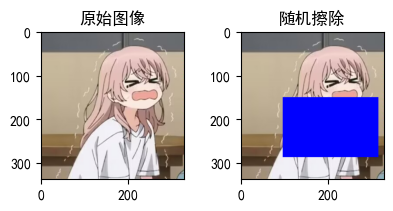

In [36]:
raw_img = read_image('sticker.jpeg')
show_image([
    (
        raw_img, '原始图像'
    ),
    (
        transforms.RandomErasing(p=1, scale=(0.2, 0.3),ratio=(0.5, 1.0),value=(0, 0, 255))(raw_img),
        "随机擦除"
    )
])

#### RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)

对图像中各像素数据类型进行转换。

- dtype : 输出图像中各个像素的数据类型

In [37]:
raw_img = read_image('sticker.jpeg')

In [38]:
print(f'转换前数据类型为：{raw_img.dtype}')


转换前数据类型为：torch.uint8


In [39]:
img = transforms.ConvertImageDtype(dtype=torch.float32)(raw_img)

In [40]:
print(f'转换前数据类型后：{img.dtype}')

转换前数据类型后：torch.float32


### 转换类型的图像变换API

#### ToPILImage([mode])

将torch.Tensor或numpy.ndarray类型图像转为PIL.Image类型图像。

- mode: PIL.Image模式

In [41]:
raw_img = read_image('sticker.jpeg')
print(f'转换前图像类型为：{type(raw_img)}')
img = transforms.ToPILImage()(raw_img)
print(f'转换后图像类型为：{type(img)}')

转换前图像类型为：<class 'torch.Tensor'>
转换后图像类型为：<class 'PIL.Image.Image'>


#### ToTensor()

将PIL.Image或numpy.ndarray类型图像转为torch.Tensor类型图像。

In [42]:
raw_img = Image.open('sticker.jpeg')
print(f'转换前图像类型为：{type(raw_img)}')
img = transforms.ToTensor()(raw_img)
print(f'转换后图像类型为：{type(img)}')

转换前图像类型为：<class 'PIL.JpegImagePlugin.JpegImageFile'>
转换后图像类型为：<class 'torch.Tensor'>


#### PILToTensor()

将PIL.Image(shape为：(H x W x C))类型图像转为torch.Tensor(shape为： (C x H x W))。

In [43]:
raw_img = Image.open('sticker.jpeg')

print(f'转换前图像类型为：{type(raw_img)}，') 

img = transforms.ToTensor()(raw_img)
print(f'转换后图像类型为：{type(img)}')

转换前图像类型为：<class 'PIL.JpegImagePlugin.JpegImageFile'>，
转换后图像类型为：<class 'torch.Tensor'>
